# Training Your Own "Dense Passage Retrieval" Model

Haystack contains all the tools needed to train your own Dense Passage Retrieval model.
This tutorial will guide you through the steps required to create a retriever that is specifically tailored to your domain.

## Installing Haystack

To start, let's install the latest release of Haystack with `pip`:

In [ ]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,elasticsearch,faiss]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 713.1/713.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.9/299.9 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


### Enabling Telemetry 
Knowing you're using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry) for more details.

In [ ]:
from haystack.telemetry import tutorial_running

tutorial_running(9)

## Logging

We configure how logging messages should be displayed and which log level should be used before importing Haystack.
Example log message:
INFO - haystack.utils.preprocessing -  Converting data/tutorial1/218_Olenna_Tyrell.txt
Default log level in basicConfig is WARNING so the explicit parameter is not necessary but can be changed easily:

In [ ]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [ ]:
# Here are some imports that we'll need

from haystack.nodes import DensePassageRetriever
from haystack.utils import fetch_archive_from_http
from haystack.document_stores import InMemoryDocumentStore

In [ ]:
from haystack.document_stores import FAISSDocumentStore

document_store = FAISSDocumentStore(embedding_dim=768, faiss_index_factory_str="Flat")

In [ ]:
!unzip dataTwo.zip

Archive:  dataTwo.zip
   creating: dataTwo/
  inflating: dataTwo/1.txt           
  inflating: dataTwo/10.txt          
  inflating: dataTwo/100.txt         
  inflating: dataTwo/101.txt         
  inflating: dataTwo/102.txt         
  inflating: dataTwo/103.txt         
  inflating: dataTwo/104.txt         
  inflating: dataTwo/105.txt         
  inflating: dataTwo/106.txt         
  inflating: dataTwo/107.txt         
  inflating: dataTwo/108.txt         
  inflating: dataTwo/109.txt         
  inflating: dataTwo/11.txt          
  inflating: dataTwo/110.txt         
  inflating: dataTwo/111.txt         
  inflating: dataTwo/112.txt         
  inflating: dataTwo/113.txt         
  inflating: dataTwo/114.txt         
  inflating: dataTwo/115.txt         
  inflating: dataTwo/116.txt         
  inflating: dataTwo/117.txt         
  inflating: dataTwo/118.txt         
  inflating: dataTwo/119.txt         
  inflating: dataTwo/12.txt          
  inflating: dataTwo/120.txt         
  infl

In [ ]:
from haystack.utils import convert_files_to_docs, fetch_archive_from_http, clean_wiki_text


# Let's first get some files that we want to use
doc_dir = "/content/dataTwo"
# Convert files to dicts
docs = convert_files_to_docs(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

# Now, let's write the dicts containing documents to our DB.
document_store.write_documents(docs)

INFO:haystack.utils.preprocessing:Converting /content/dataTwo/559.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/41.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/28.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/60.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/298.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/348.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/125.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/419.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/459.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/57.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/111.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/146.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/408.txt
INFO:haystack.utils.preprocessing:Converting /content/dataTwo/360.txt
INFO:haystack.utils.prep

Writing Documents:   0%|          | 0/551 [00:00<?, ?it/s]

## Training Data

DPR training performed using Information Retrieval data.
More specifically, you want to feed in pairs of queries and relevant documents.

To train a model, we will need a dataset that has the same format as the original DPR training data.
Each data point in the dataset should have the following dictionary structure.

``` python
    {
        "dataset": str,
        "question": str,
        "answers": list of str
        "positive_ctxs": list of dictionaries of format {'title': str, 'text': str, 'score': int, 'title_score': int, 'passage_id': str}
        "negative_ctxs": list of dictionaries of format {'title': str, 'text': str, 'score': int, 'title_score': int, 'passage_id': str}
        "hard_negative_ctxs": list of dictionaries of format {'title': str, 'text': str, 'score': int, 'title_score': int, 'passage_id': str}
    }
```

`positive_ctxs` are context passages which are relevant to the query.
In some datasets, queries might have more than one positive context
in which case you can set the `num_positives` parameter to be higher than the default 1.
Note that `num_positives` needs to be lower or equal to the minimum number of `positive_ctxs` for queries in your data.
If you have an unequal number of positive contexts per example,
you might want to generate some soft labels by retrieving similar contexts which contain the answer.

DPR is standardly trained using a method known as in-batch negatives.
This means that positive contexts for a given query are treated as negative contexts for the other queries in the batch.
Doing so allows for a high degree of computational efficiency, thus allowing the model to be trained on large amounts of data.

`negative_ctxs` is not actually used in Haystack's DPR training so we recommend you set it to an empty list.
They were used by the original DPR authors in an experiment to compare it against the in-batch negatives method.

`hard_negative_ctxs` are passages that are not relevant to the query.
In the original DPR paper, these are fetched using a retriever to find the most relevant passages to the query.
Passages which contain the answer text are filtered out.

If you'd like to convert your SQuAD format data into something that can train a DPR model,
check out the utility script at [`haystack/utils/squad_to_dpr.py`](https://github.com/deepset-ai/haystack/blob/main/haystack/utils/squad_to_dpr.py)

## Using Question Answering Data

Question Answering datasets can sometimes be used as training data.
Google's Natural Questions dataset, is sufficiently large
and contains enough unique passages, that it can be converted into a DPR training set.
This is done simply by considering answer containing passages as relevant documents to the query.

The SQuAD dataset, however, is not as suited to this use case since its question and answer pairs
are created on only a very small slice of wikipedia documents.

## Download Original DPR Training Data

WARNING: These files are large! The train set is 7.4GB and the dev set is 800MB

We can download the original DPR training data with the following cell.
Note that this data is probably only useful if you are trying to train from scratch.

## Option 2: Finetuning DPR

If you have your own domain specific question answering or information retrieval dataset,
you might instead be interested in finetuning a pretrained DPR model.
In this case, you would initialize both query and passage models using the original pretrained model.
You will want to load something like this set of variables instead of the ones above

In [ ]:
import json
import random

# Set the random seed for reproducibility
random.seed(42)

# Read dataset from test.json file
with open('/content/CombinedData.json', 'r') as file:
    dataset = json.load(file)

# Shuffle the dataset
random.shuffle(dataset)

# Split the dataset into train, dev, and test sets
train_ratio = 0.7  # 70% for training
dev_ratio = 0.15  # 15% for development
test_ratio = 0.15  # 15% for testing

total_samples = len(dataset)
train_samples = int(total_samples * train_ratio)
dev_samples = int(total_samples * dev_ratio)

train_set = dataset[:train_samples]
dev_set = dataset[train_samples:train_samples + dev_samples]
test_set = dataset[train_samples + dev_samples:]

# Save train set to train.json
with open('train.json', 'w') as file:
    json.dump(train_set, file)

# Save dev set to dev.json
with open('dev.json', 'w') as file:
    json.dump(dev_set, file)

# Save test set to test.json
with open('test.json', 'w') as file:
    json.dump(test_set, file)


In [ ]:
# Here are the variables you might want to use instead of the set above
# in order to perform pretraining

doc_dir = "/content/dataTwo"
train_filename = "/content/train.json"
test_filename="/content/test.json"
dev_filename = "/content/dev.json"

query_model = "facebook/dpr-question_encoder-single-nq-base"
passage_model = "facebook/dpr-ctx_encoder-single-nq-base"

save_dir = "/content/dpr"

## Initialization

Here we want to initialize our model either with plain language model weights for training from scratch
or else with pretrained DPR weights for finetuning.
We follow the [original DPR parameters](https://github.com/facebookresearch/DPR#best-hyperparameter-settings)
for their max passage length but set max query length to 64 since queries are very rarely longer.

In [ ]:
from haystack.nodes import DensePassageRetriever

retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model=query_model,
    passage_embedding_model=passage_model,
)

document_store.update_embeddings(retriever)

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
INFO:haystack.modeling.model.language_model:Auto-detected model language: english


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.document_stores.faiss:Updating embeddings for 549 docs...


Updating Embedding:   0%|          | 0/549 [00:00<?, ? docs/s]

Create embeddings:   0%|          | 0/560 [00:00<?, ? Docs/s]

## Training

Let's start training and save our trained model!

On a V100 GPU, you can fit up to batch size 16 so we set gradient accumulation steps to 8 in order
to simulate the batch size 128 of the original DPR experiment.

When `embed_title=True`, the document title is prepended to the input text sequence with a `[SEP]` token
between it and document text.

When training from scratch with the above variables, 1 epoch takes around an hour and we reached the following performance:

```
loss: 0.046580662854042276
task_name: text_similarity
acc: 0.992524064068483
f1: 0.8804297774366846
acc_and_f1: 0.9364769207525838
average_rank: 0.19631619339984652
report:
                precision    recall  f1-score   support

hard_negative     0.9961    0.9961    0.9961    201887
     positive     0.8804    0.8804    0.8804      6515

     accuracy                         0.9925    208402
    macro avg     0.9383    0.9383    0.9383    208402
 weighted avg     0.9925    0.9925    0.9925    208402

```

In [ ]:

retriever.train(
    data_dir=doc_dir,
    train_filename=train_filename,
    dev_filename=dev_filename,
    test_filename=test_filename,
    n_epochs=10,
    batch_size=16,
    grad_acc_steps=8,
    save_dir=save_dir,
    evaluate_every=3000,
    embed_title=True,
    num_positives=1,
    num_hard_negatives=1,
)




INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|
 (o)(o)------'\ _ /     ( )
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: /content/train.json 


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING DEV DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:Loading dev set from: /content/dev.json


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING TEST DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:Loading test set from: /content/test.json


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:DATASETS SUMMARY
INFO:haystack.modeling.data_handler.data_silo:================
INFO:haystack.modeling.data_handler.data_silo:Examples in train: 202
INFO:haystack.modeling.data_handler.data_silo:Examples in dev  : 43
INFO:haystack.modeling.data_handler.data_silo:Examples in test : 44
INFO:haystack.modeling.data_handler.data_silo:Total examples   : 289
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:Longest query length observed after clipping: 38   - for max_query_len: 64
INFO:haystack.modeling.data_handler.data_silo:Average query length after clipping:          14.227722772277227
INFO:haystack.modeling.data_handler.data_silo:Proportion queries clipped:                   0.0
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:Longest passage length observed after clipping: 155.5   - for max_passage_len: 256
IN

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:haystack.modeling.evaluation.eval:

\\|//       \\|//      \\|//       \\|//     \\|//
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
***************************************************
***** EVALUATION | TEST SET | AFTER 130 BATCHES *****
***************************************************
\\|//       \\|//      \\|//       \\|//     \\|//
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

INFO:haystack.modeling.evaluation.eval:
 _________ text_similarity _________
INFO:haystack.modeling.evaluation.eval:loss: 0.02216313085095449
INFO:haystack.modeling.evaluation.eval:task_name: text_similarity
INFO:haystack.modeling.evaluation.eval:acc: 0.9954268292682927
INFO:haystack.modeling.evaluation.eval:f1: 0.9318181818181818
INFO:haystack.modeling.evaluation.eval:acc_and_f1: 0.9636225055432373
INFO:haystack.modeling.evaluation.eval:average_rank: 0.06818181818181818
INFO:haystack.modeling.evaluation.eval:report: 
                precision    recall  f1-score   support

hard_ne

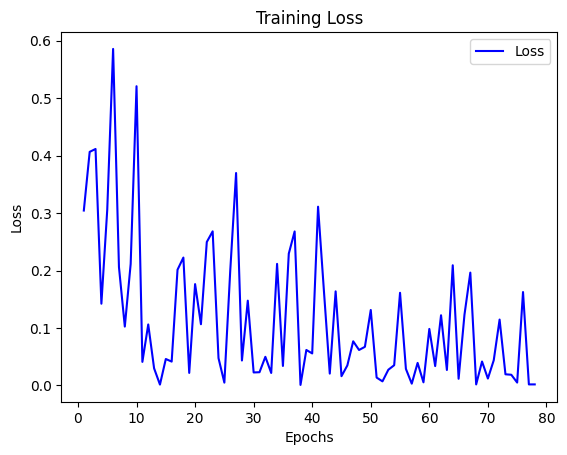

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the loss and confusion matrix values stored in variables
loss = [0.3044, 0.4065, 0.4115, 0.1423, 0.3059, 0.5856, 0.2060, 0.1025, 0.2115, 0.5207, 0.0411, 0.1062, 0.0299, 0.0016, 0.0461, 0.0416, 0.2014, 0.2226, 0.0219, 0.1764, 0.1066, 0.2497, 0.2682, 0.0476, 0.0050, 0.1991, 0.3697, 0.0435, 0.1476, 0.0227, 0.0231, 0.0499, 0.0218, 0.2116, 0.0340, 0.2294, 0.2680, 0.0010, 0.0618, 0.0558, 0.3111, 0.1647, 0.0207, 0.1638, 0.0162, 0.0349, 0.0769, 0.0618, 0.0673, 0.1314, 0.0138, 0.0072, 0.0274, 0.0353, 0.1613, 0.0289, 0.0032, 0.0393, 0.0055, 0.0984, 0.0338, 0.1222, 0.0270,0.2092,0.0117, 0.123,0.1964,0.0019, 0.0417,0.0121,0.0439, 0.1147,0.0195,0.0187,0.0051 ,0.1626, 0.0019,0.0019]

# Plot the loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



## Loading

Loading our newly trained model is simple!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reloaded_retriever = DensePassageRetriever.load(load_dir=save_dir, document_store=None)

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
INFO:haystack.nodes.retriever.dense:DPR model loaded from /content/dpr
